# Naive Bayes

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("darkgrid")

from math import sqrt, pi

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML

**Essencial que o aluno conheça:**

- O que é uma Distribuição Gaussiana.
- Dóminio da biblioteca pandas.
- Básico de machine learning (exemplo: porque separar dados em treino e test).

**Desejável que o aluno conheça:**
- Probabilidade condicional (Bayes).
- Probability density functions.

**O que vamos aprender?**

- Como funciona o algoritmo ```Gaussian naive bayes```.
- Como ele se relaciona com outros algoritmos baseados em ```naive bayes```.
- Exemplo de aplicação em textos.

## Functions 

In [2]:
def prepareData(sklearnDataSet):
    
    X, y = sklearnDataSet(return_X_y=True)
    data  = np.hstack([X,y.reshape(-1,1)])
    cols_name_lst = [f"feature_{i+1}" for i in range(X.shape[1])] + ["target"]
    return pd.DataFrame(data, columns = cols_name_lst)

def getStats(df):
    
    classes = list(map(int, df.target.unique()))
    return df.groupby("target")\
             .agg(["mean","std"]).T\
             .reset_index()\
             .rename(columns = {"level_0":"feature","level_1":"statistic"})\
             .pivot(index='feature', columns="statistic", values=classes)\
             .T\
             .sort_index()

def gaussian(x, mu, sig):
    aux = 2*(sig**2)
    return np.exp(-(x - mu)**2 /aux)/sqrt(aux)

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0\xa0"
    display(HTML(output))
    
def gaussian_plot(s, point):
    
    fig = plt.figure(figsize=(20,4))
    mean_lst = []
    std_lst = []
    
    feature_point = point[s.name]
    
    #Split column in means and standard deviations
    for mean, std in zip(s[0::2],s[1::2]):
        mean_lst.append(mean)
        std_lst.append(std)

    max_mean = max(mean_lst)
    min_mean = min(mean_lst)
    max_std  = max(std_lst)  
    
    #Make x axis 
    x = np.linspace(min(mean_lst)-3*max_std, max(mean_lst)+3*max_std, 5000)
    
    #Store likelihood for every class
    y_probability = []
    
    for index, stats in enumerate(zip(mean_lst, std_lst)):
        
        mean, std = stats
        
        y = [gaussian(i, mean, std) for i in x]
        plt.title(fr"PDF: {s.name.upper()}")
        plt.plot(x, y, lw=2,label=fr"$\mu: {round(mean,2)} , \sigma: {round(std,2)}$")
        
        # Calculate likelihood for an given point
        y_point = gaussian(feature_point, mean, std)
        #Store the log to prevent underflow while multiplicating
        y_probability.append(np.log(y_point))
        plt.vlines(x=feature_point, ymin=0, ymax = y_point, linewidth=1, color='k', linestyles = "dashdot")
        plt.hlines(y=y_point, xmin=x[0], xmax = feature_point, linewidth=1, color='k', linestyles = "dashdot")
        plt.scatter(feature_point, y_point, s = 50)

        
    first_legend = plt.legend(loc="upper left", title=r"Stats", fancybox=True, fontsize=16)
    plt.setp(first_legend.get_title(),fontsize=18)
    plt.gca().add_artist(first_legend)
    
    second_legend = plt.legend(list(range(len(s)//2)),
                               title="Classes",
                               fancybox=True, 
                               fontsize=16,
                               loc='upper right')    
    
    plt.setp(second_legend.get_title(),fontsize=18)       
    plt.show()
    plt.close()
    
    return pd.Series(y_probability)

## Carregando os datasets 

In [3]:
"""
Tumor maligno ou benigno
"""
cancer_df = prepareData(load_breast_cancer)
iris_df = prepareData(load_iris)

### Escolha o dataset

In [4]:
df = cancer_df

### Split dos dados

In [5]:
#A ultima coluna é o target. Outras colunas sao features.
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 42)
display_side_by_side([df_train.head(3), df_test.head(3)], ["Train", "Test"])

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,target
82,25.220000,24.910000,171.500000,1878.000000,0.106300,0.266500,0.333900,0.184500,0.182900,0.067820,0.897300,1.474000,7.382000,120.000000,0.008166,0.056930,0.057300,0.020300,0.010650,0.005893,30.000000,33.620000,211.700000,2562.000000,0.157300,0.607600,0.647600,0.286700,0.235500,0.105100,0.000000
39,13.480000,20.820000,88.400000,559.200000,0.101600,0.125500,0.106300,0.054390,0.172000,0.064190,0.213000,0.591400,1.545000,18.520000,0.005367,0.022390,0.030490,0.012620,0.013770,0.003187,15.530000,26.020000,107.300000,740.400000,0.161000,0.422500,0.503000,0.225800,0.280700,0.107100,0.000000
271,11.290000,13.040000,72.230000,388.000000,0.098340,0.076080,0.032650,0.027550,0.176900,0.062700,0.190400,0.529300,1.164000,13.170000,0.006472,0.011220,0.012820,0.008849,0.016920,0.002817,12.320000,16.180000,78.270000,457.500000,0.135800,0.150700,0.127500,0.087500,0.273300,0.080220,1.000000
,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,target
204,12.470000,18.600000,81.090000,481.900000,0.099650,0.105800,0.080050,0.038210,0.192500,0.063730,0.396100,1.044000,2.497000,30.290000,0.006953,0.019110,0.027010,0.010370,0.017820,0.003586,14.970000,24.640000,96.050000,677.900000,0.142600,0.237800,0.267100,0.101500,0.301400,0.087500,1.000000
70,18.940000,21.310000,123.600000,1130.000000,0.090090,0.102900,0.108000,0.079510,0.158200,0.054610,0.788800,0.797500,5.486000,96.050000,0.004444,0.016520,0.022690,0.013700,0.013860,0.001698,24.860000,26.580000,165.900000,1866.000000,0.119300,0.233600,0.268700,0.178900,0.255100,0.065890,0.000000
131,15.460000,19.480000,101.700000,748.900000,0.109200,0.122300,0.146600,0.080870,0.193100,0.057960,0.474300,0.785900,3.094000,48.310000,0.006240,0.014840,0.028130,0.010930,0.013970,0.002461,19.260000,26.000000,124.900000,1156.000000,0.154600,0.239400,0.379100,0.151400,0.283700,0.080190,0.000000


## Gaussian Naive Bayes 

### Teoria 

Nos queremos calcular a "probabilidade" de Y ser de uma classe, com base em um conjunto de features, matematicamente $P(y|x_1, ..., x_n)$:

\begin{equation}
P(y|x_1, ..., x_n) = \frac{P(y)P(x_1, ..., x_n|y)}{P(x_1, ..., x_n)}\\
\end{equation}

Nessa equação $P(y)$ é denominado ```probabilidade a priori```. Nós podemos usar simplesmente essa probabilidade para classificar. 

Exemplo: Suponha que voce queira saber se a próxima pessoa a passar pela porta de uma loja em especifico vai ser homem ou mulher. Além disso, vamos supor também que, foi medido empericamente e 60\% das pessoas que entram são mulheres enquanto 40\% são homens, isso é, a probabilidade a priori. Se a gente, só tem essa informação vamos dizer que a próxima pessoa a entrar é uma mulher.

Entretanto, se tivermos dados podemos fazer melhor, suponha que as vezes colocam um letreiro na frente da loja falando sobre roupas masculinas, talvez faça mais homens entrarem, o que a gente quer saber é dado que existe o letreiro qual a probabilidade de um homem|mulher entrar na loja, matematicamente, $P(y=\text{homem}|\text{letreiro})$ e $P(y=\text{mulher}|\text{letreiro})$. 

Usando a equação anterior (Teorema de Bayes) podemos escrever 
$$P(y=homem|letreiro) = \frac{P(y=homem)P(letreiro|y=homem)}{P(letreiro)}
$$


$$
P(y=mulher|letreiro) = \frac{P(y=mulher)P(letreiro|y=mulher)}{P(letreiro)}
$$

Usando dados historicos podemos calcular a probabilidade para cada classe e selecionar a classe com maior probabilidade.

---

Na nossa história o letreiro é uma feature, mas no mundo real utilizamos várias features e para simplificar os cálculos fazemos a suposição de ```indepêndencia condicional``` entre cada par de features, dessa forma, reescrevemos a equação anterior da seguinte maneira:

$$
P(y|x_1, ..., x_n) = \frac{P(y)\prod_{i=1}^{n}P(x_i|y)}{P(x_1, ..., x_n)}\\
$$


---

Como o termo $P(x_1, ..., x_n)$ é constnte, a gente pode usar a seguinte regra de classificação:

$$
P(y|x_1, ..., x_n) \propto P(y)\prod_{i=1}^{n}P(x_i|y) \\
$$

---

Como vamos trabalhar com números pequenos utilizamos um truque matemático para previnir underflow. Basicamente aplicamos a operação logaritimica, assim as multiplicações viram somas:

$$
logP(y|x_1, ..., x_n) \propto logP(y) + \sum_{i=1}^{n}logP(x_i|y) \\
$$

---

**Premissas:** As features tem uma distribuição gaussiana.

<details><summary><b>O QUE FAZER??</b></summary>
<img style="width: 400px;" src="figures/meme1.jpg">

obs: Apesar de isso não ser verdade em diversos cenários, já foi reportado bons resultados para diversas aplicações.

**Gaussian equation**:
    
$$
P(X_i | y) = \frac{1}{\sqrt{2\pi\sigma_y^{2}}}\exp{\frac{-(x_i - \mu_y)^{2}}{2\sigma_y^{2}}}
$$

### Dataset ```prior probability``` 

Depois dessa conversa sobre probabilidade vamos calcular as ```prior probabilities``` para cada classe, pois elas vão ser importantes.

In [6]:
#prior probability
prior_df = df["target"]\
             .value_counts(normalize=True)\
             .reset_index(name="prior_probability")\
             .rename(columns = {"index":"class"})\
             .set_index("class")
prior_df

,prior_probability
class,
1.0,0.627417
0.0,0.372583


### Dataset ```mean``` e ```standard deviation```

Como o nome diz gaussian é interessante calcular as médias e desvio padrão das features, porque provavelmente a gente vai utilizar.

**Utilizando os dados de treino!!**

---

<details><summary><b>SPOILER</b></summary>
    
    A gente vai usar :)
    

In [7]:
stats_df = getStats(df_train)
stats_df

feature      feature_1  feature_10  feature_11  feature_12  feature_13  \
  statistic                                                              
0 mean       17.420872    0.062737    0.609829    1.215447    4.330641   
  std         3.269915    0.007754    0.356119    0.477792    2.645414   
1 mean       12.173842    0.062783    0.282373    1.213736    1.997480   
  std         1.793027    0.006781    0.109341    0.590460    0.755719   

feature      feature_14  feature_15  feature_16  feature_17  feature_18  ...  \
  statistic                                                              ...   
0 mean        72.936974    0.006853    0.032492    0.042392    0.015244  ...   
  std         63.539832    0.002948    0.018570    0.021943    0.005650  ...   
1 mean        21.117729    0.007109    0.021545    0.026549    0.009859  ...   
  std          8.771352    0.003022    0.016937    0.034392    0.005747  ...   

feature      feature_28  feature_29   feature_3  feature_30   feature_4  \
  statistic                                                               
0 mean         0.182564    0.325534  115.079128    0.091672  975.335897   
  std          0.046398    0.076391   22.250138    0.021871  376.680538   
1 mean         0.074579    0.269338   78.248265    0.079526  465.089590   
  std          0.036329    0.041295   11.894030    0.014060  135.785508   

feature      feature_5  feature_6  feature_7  feature_8  feature_9  
  statistic                                                         
0 mean        0.102842   0.145239   0.160762   0.087377   0.193436  
  std         0.012760   0.054032   0.074483   0.033938   0.027937  
1 mean        0.091880   0.079642   0.046449   0.025466   0.173081  
  std         0.013062   0.034333   0.044886   0.015716   0.024648  

[4 rows x 30 columns]

In [8]:
stats_df.index = map(lambda x: '_'.join(map(str,x)), stats_df.index)
stats_df = stats_df[sorted(stats_df.columns, key=lambda x: int(x.split('_')[1]))]
qtd_classes = len(stats_df)//2
stats_df

feature,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0_mean,17.420872,21.572359,115.079128,975.335897,0.102842,0.145239,0.160762,0.087377,0.193436,0.062737,...,21.072872,29.368769,140.954923,1417.431282,0.145154,0.376601,0.453310,0.182564,0.325534,0.091672
0_std,3.269915,3.797949,22.250138,376.680538,0.012760,0.054032,0.074483,0.033938,0.027937,0.007754,...,4.364486,5.466704,29.856239,612.402699,0.022298,0.168342,0.179633,0.046398,0.076391,0.021871
1_mean,12.173842,17.894921,78.248265,465.089590,0.091880,0.079642,0.046449,0.025466,0.173081,0.062783,...,13.414224,23.537098,87.291009,562.298423,0.124248,0.182676,0.168400,0.074579,0.269338,0.079526
1_std,1.793027,3.985937,11.894030,135.785508,0.013062,0.034333,0.044886,0.015716,0.024648,0.006781,...,2.000879,5.513397,13.677011,165.936074,0.019966,0.092941,0.144188,0.036329,0.041295,0.014060


### Plotando probabilidades

Já que a gente calculou as médias e desvios padrões para cada feature e nossa premissa são distribuições gaussianas, nada mais justo que plotar umas distribuições gaussianas. No caso uma distribuição para cada feature e classe. Além disso, vamos selecionar um exemplo dos **dados de test** para ver em que posição ele se encontra nessas ditribuições.

In [9]:
select_id = 5
point = df_test.iloc[select_id,:].to_dict()
print(f"Nosso exemplo é da classe: {int(df_test.iloc[select_id,-1])}")

Nosso exemplo é da classe: 0


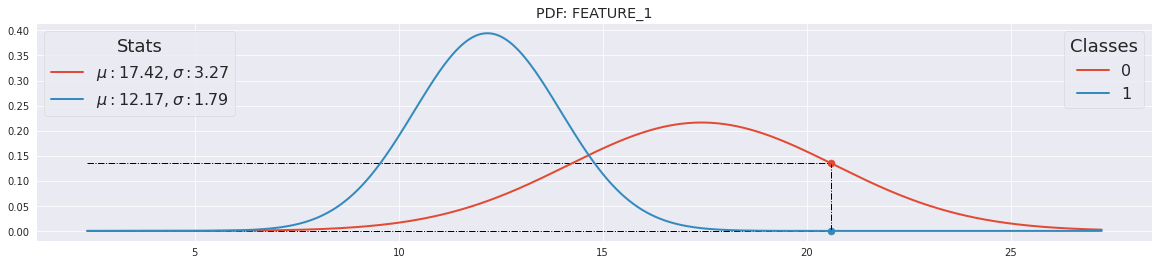

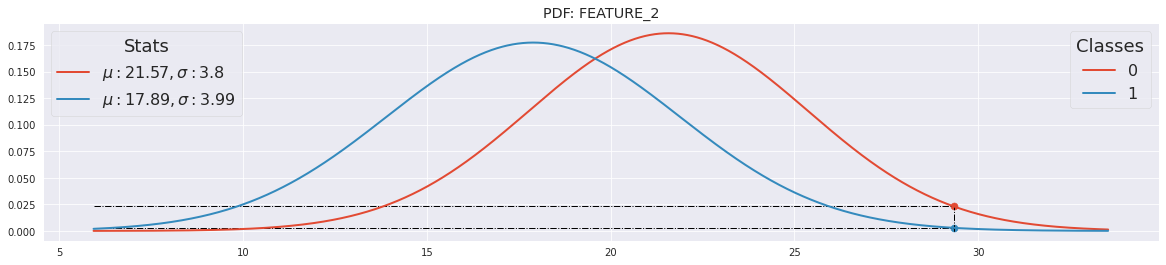

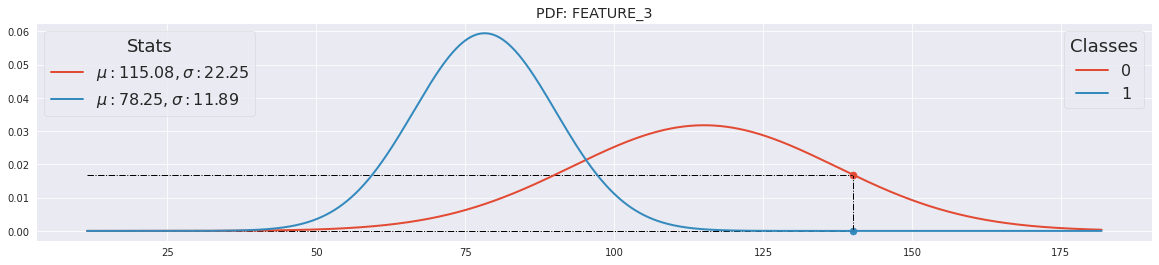

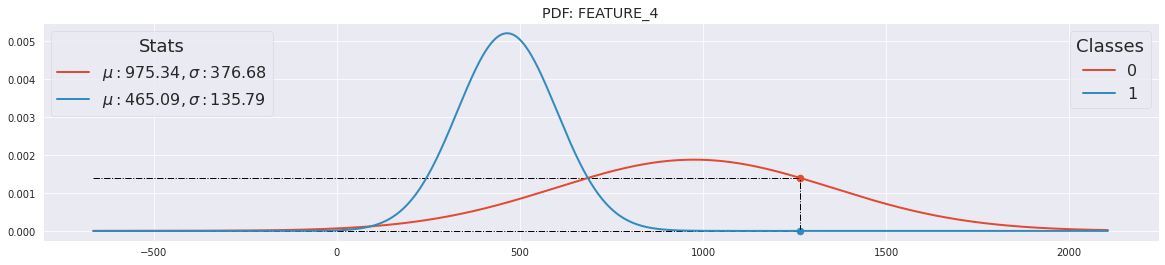

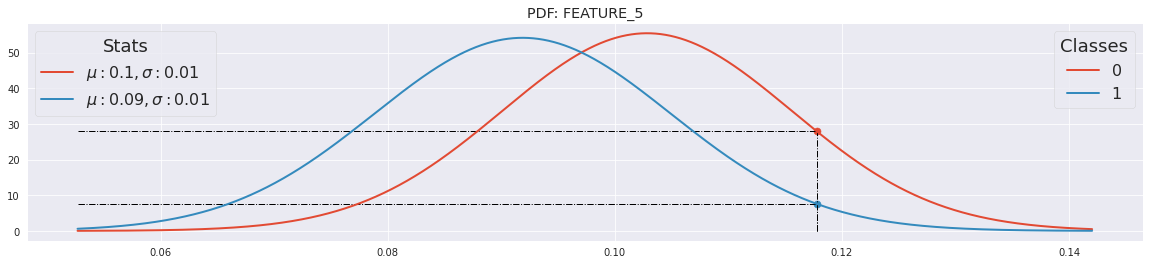

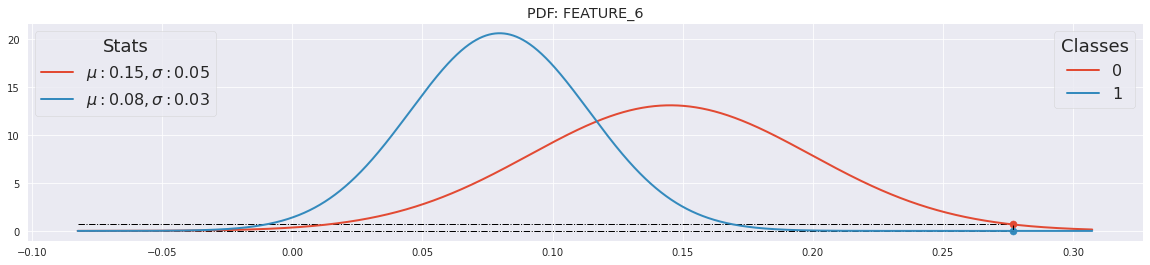

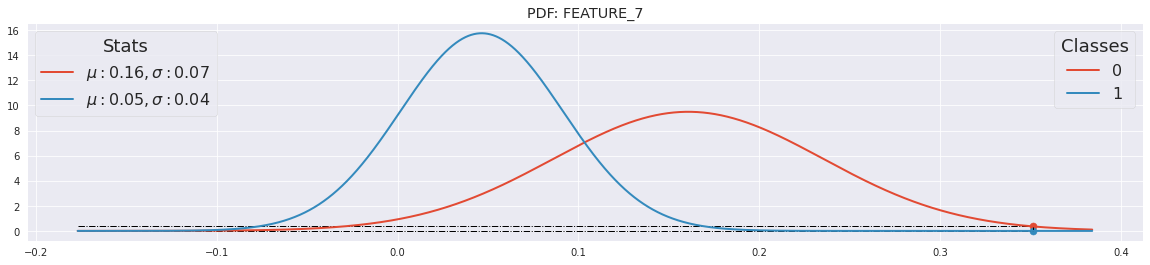

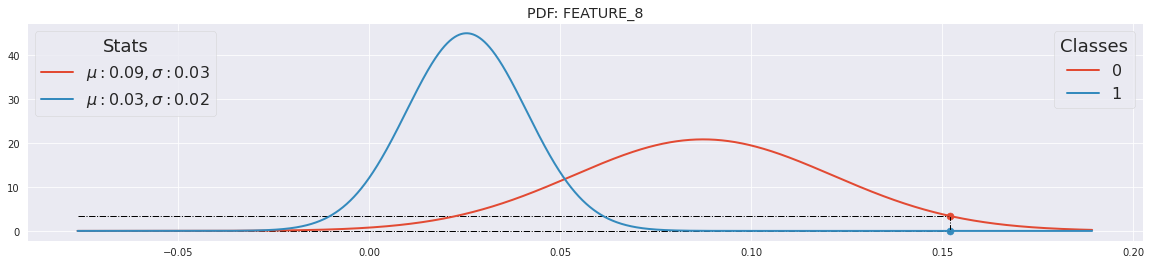

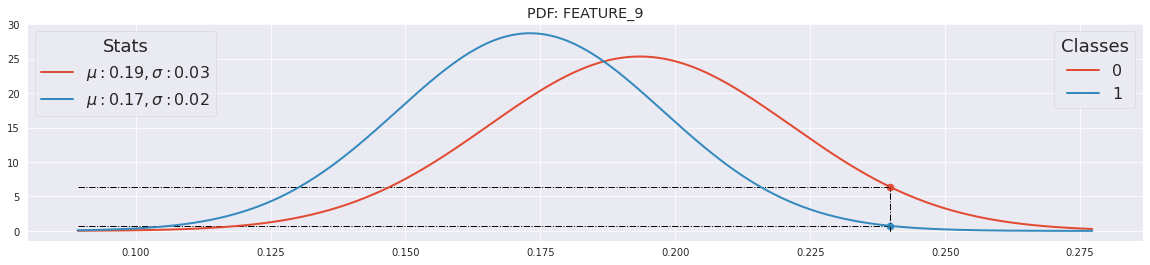

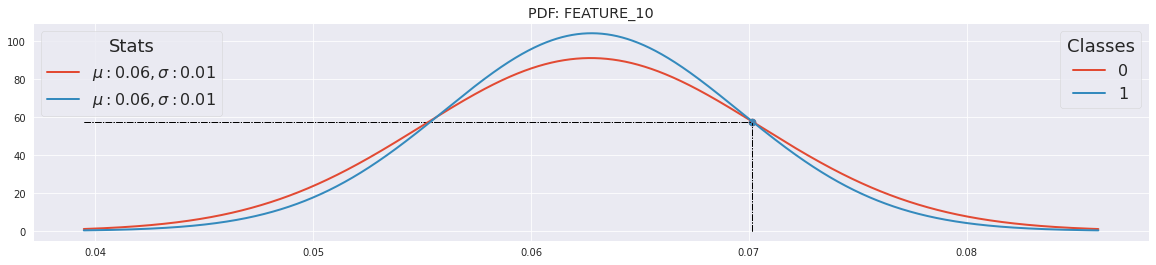

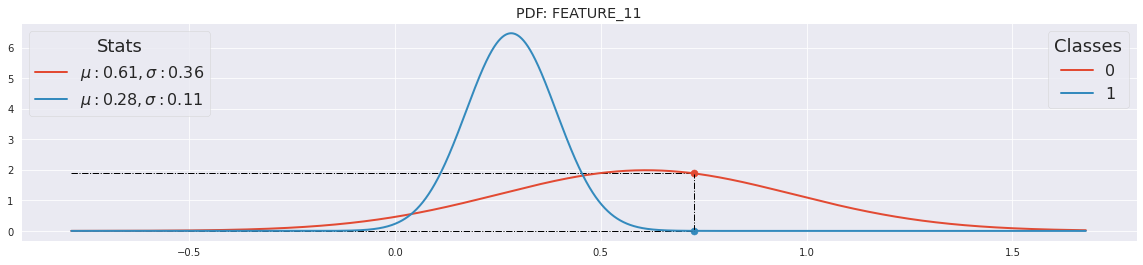

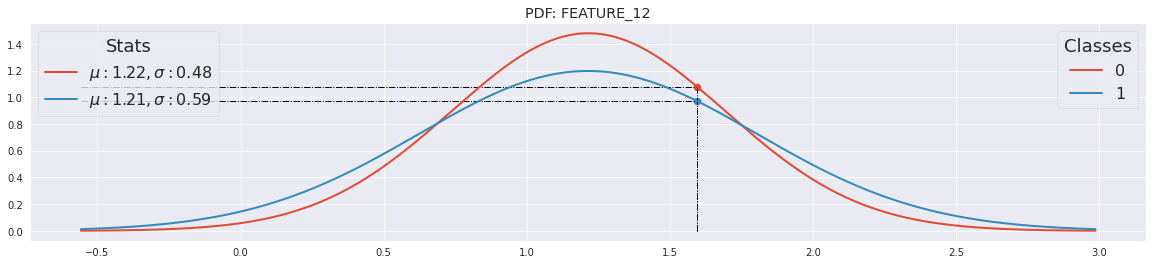

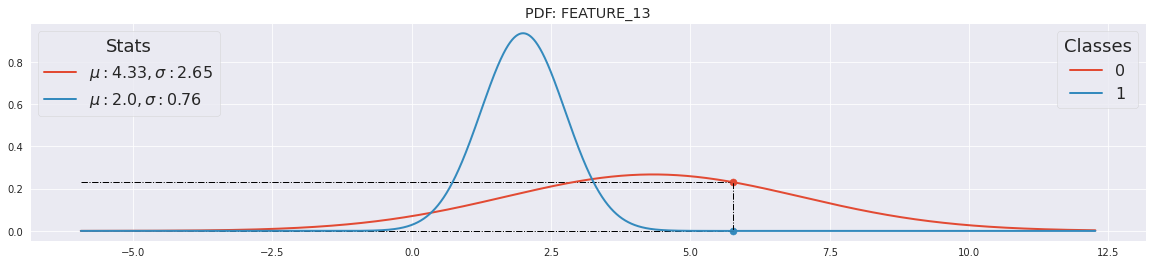

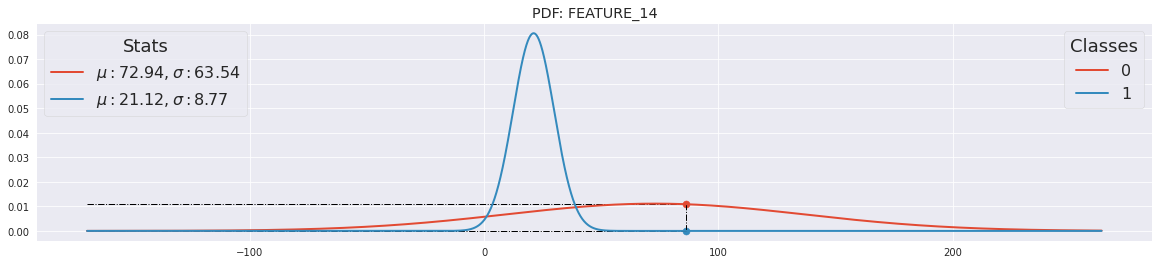

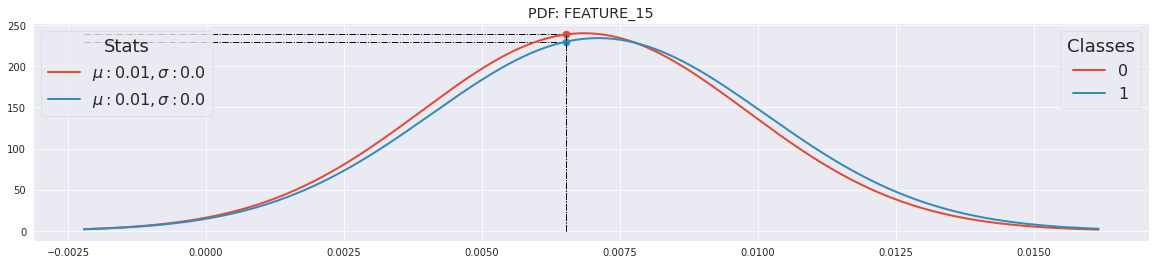

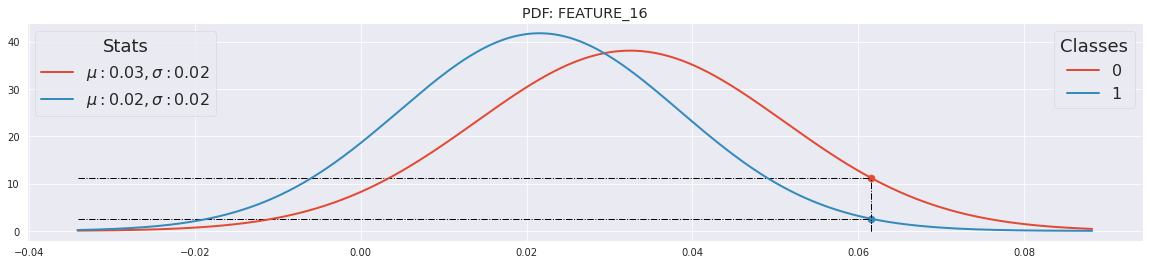

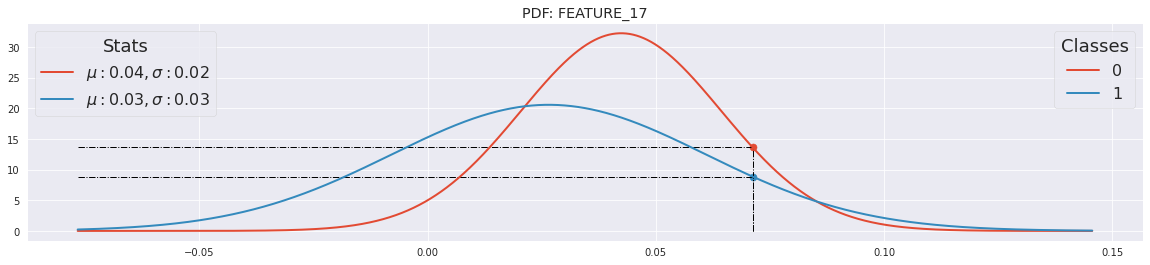

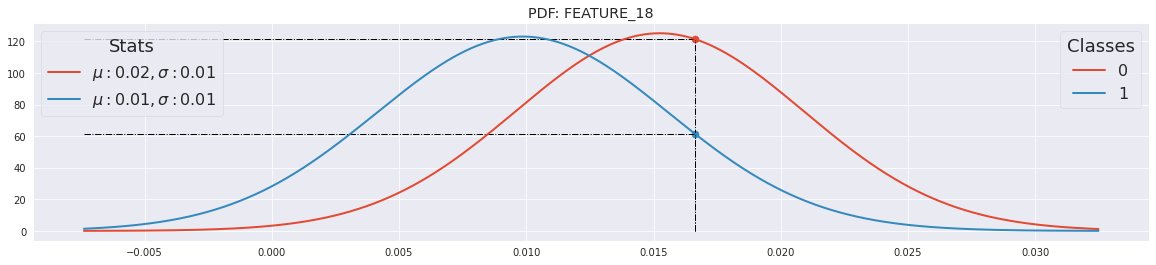

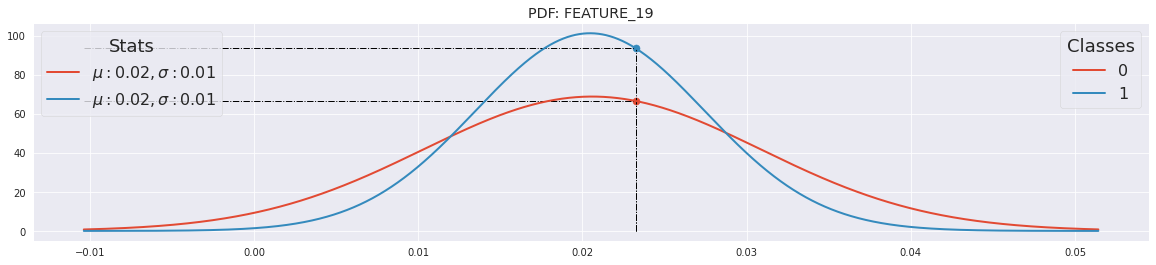

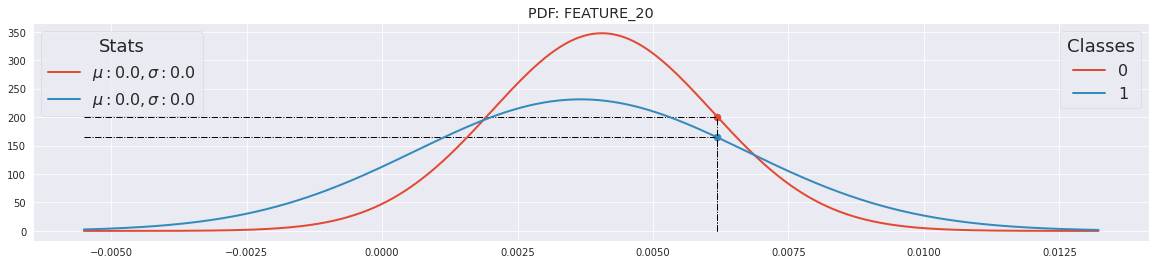

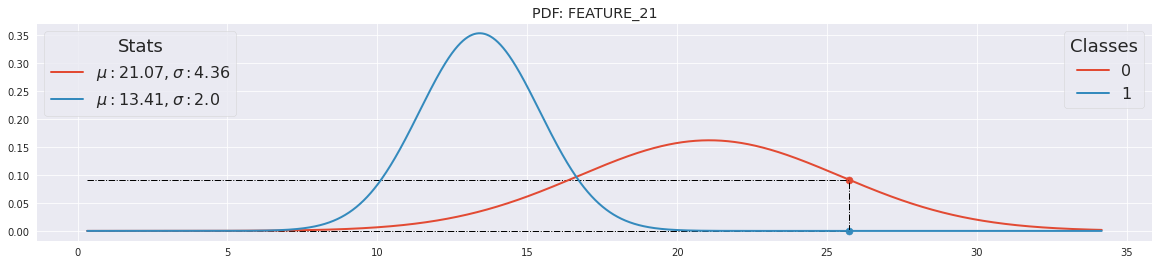

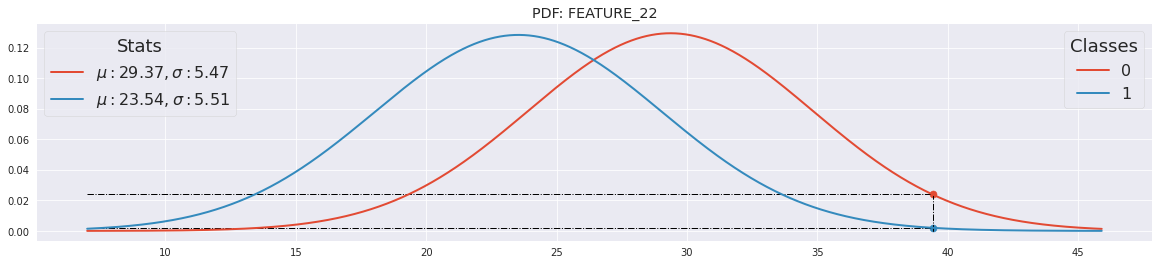

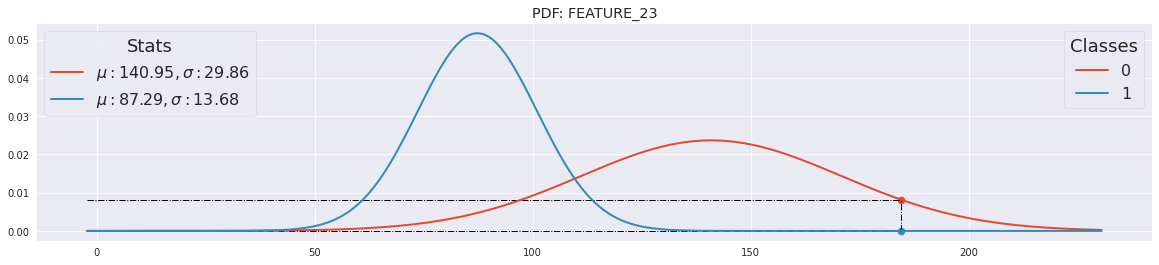

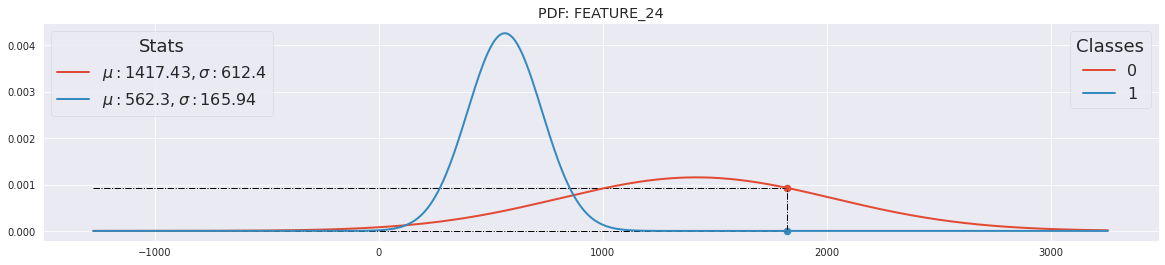

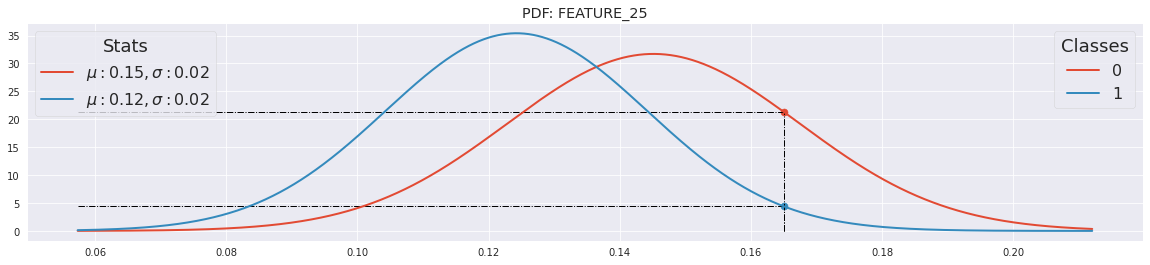

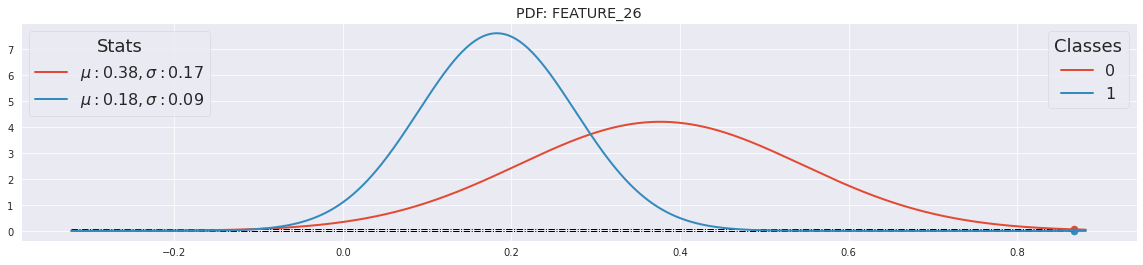

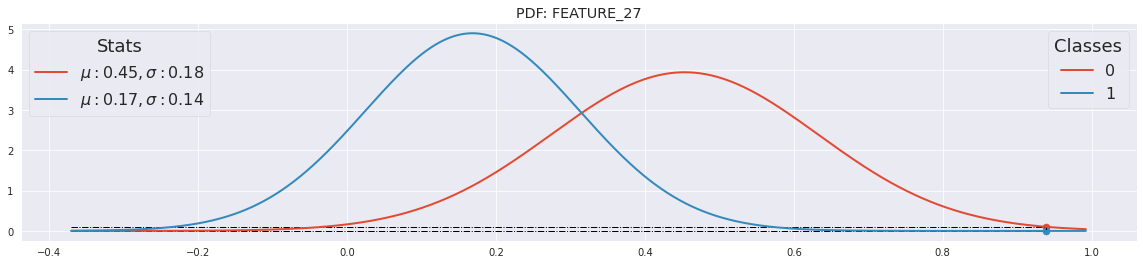

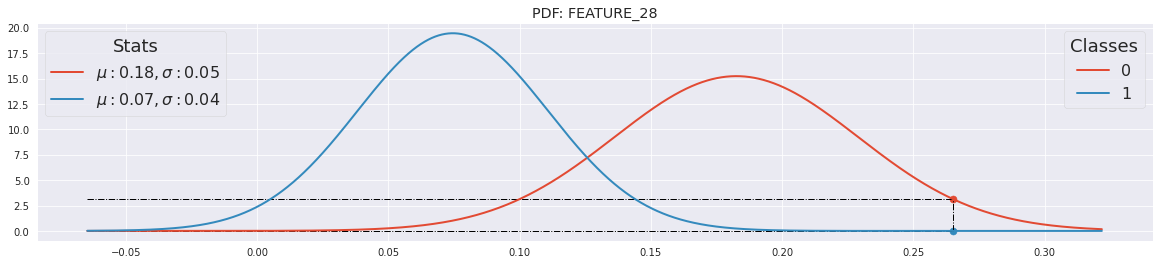

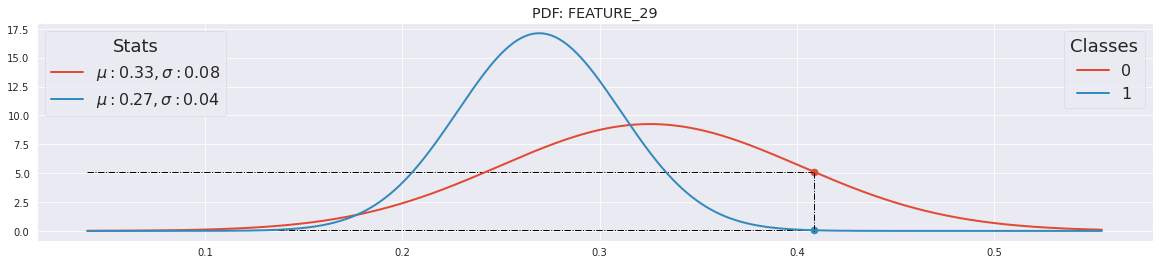

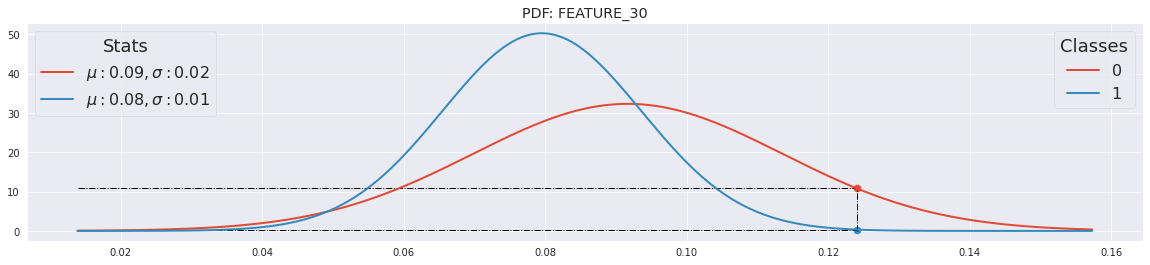

In [10]:
result = stats_df.apply(gaussian_plot, args=[point], result_type = "expand")

Esses pontos no gráfico representam o valor calculado pela seguinte equação $ P(feature|y)$. Como estamos plotando uma distribuição de de densidade esses pontos são conhecidos como ```likelihood``` de cada classe para o exemplo que está sendo analisado.

In [11]:
cols = {col:fr"P({col}|y)" for col in result.columns}
result.rename(columns=cols,inplace = True)
result.index.name = "class"
result

feature,P(feature_1|y),P(feature_2|y),P(feature_3|y),P(feature_4|y),P(feature_5|y),P(feature_6|y),P(feature_7|y),P(feature_8|y),P(feature_9|y),P(feature_10|y),...,P(feature_21|y),P(feature_22|y),P(feature_23|y),P(feature_24|y),P(feature_25|y),P(feature_26|y),P(feature_27|y),P(feature_28|y),P(feature_29|y),P(feature_30|y)
class,,,,,,,,,,,,,,,,,,,,,
0,-2.003959,-3.767115,-4.081202,-6.573645,3.327747,-0.401703,-1.024859,1.223718,1.860096,4.054773,...,-2.391820,-3.735524,-4.811457,-6.981099,3.060598,-2.826977,-2.280476,1.145575,1.632692,2.383632
1,-11.972677,-5.844513,-16.343826,-22.609503,2.022559,-13.496561,-20.321448,-28.603174,-0.296097,4.055242,...,-20.014072,-6.203211,-28.272372,-34.227784,1.484117,-25.164794,-12.680108,-10.768314,-2.854092,-1.085216


In [12]:
final_stats = pd.concat([prior_df,result],axis=1)

In [13]:
final_stats

,prior_probability,P(feature_1|y),P(feature_2|y),P(feature_3|y),P(feature_4|y),P(feature_5|y),P(feature_6|y),P(feature_7|y),P(feature_8|y),P(feature_9|y),...,P(feature_21|y),P(feature_22|y),P(feature_23|y),P(feature_24|y),P(feature_25|y),P(feature_26|y),P(feature_27|y),P(feature_28|y),P(feature_29|y),P(feature_30|y)
class,,,,,,,,,,,,,,,,,,,,,
0.0,0.372583,-2.003959,-3.767115,-4.081202,-6.573645,3.327747,-0.401703,-1.024859,1.223718,1.860096,...,-2.391820,-3.735524,-4.811457,-6.981099,3.060598,-2.826977,-2.280476,1.145575,1.632692,2.383632
1.0,0.627417,-11.972677,-5.844513,-16.343826,-22.609503,2.022559,-13.496561,-20.321448,-28.603174,-0.296097,...,-20.014072,-6.203211,-28.272372,-34.227784,1.484117,-25.164794,-12.680108,-10.768314,-2.854092,-1.085216


Agora a gente tem todos as componentes para prever a classe desse exemplo com base nas features, basta somar as linhas.

In [14]:
final_stats.apply(lambda x: x.sum(), axis=1)

class
0.0     -2.297741
1.0   -279.248445
dtype: float64

Qual seria a classe predita por esse modelo ?

### Prevendo para os dados de test

In [15]:
def get_gaussian_proba(s, stats_df, data):
    
    for feature_val in s:
        
        stats_ser = stats_df[f"{s.name}"]
        for index, stats in enumerate(zip(stats_ser[0::2],stats_ser[1::2])):
            mean, std = stats
            data[f"P({index}|{s.name})"].append(gaussian(feature_val, mean, std))
            
    return None

In [16]:
qtd_samples = df_test.shape[1]-1
data = {f"P({i%qtd_classes}|feature_{(i//qtd_classes)+1})":[] for i in range(qtd_samples*qtd_classes)}
_ = df_test.iloc[:,:-1].apply(get_gaussian_proba, args = [stats_df,data])

In [17]:
proba_test_df=pd.DataFrame(data)
proba_test_df.head(3)

,P(0|feature_1),P(1|feature_1),P(0|feature_2),P(1|feature_2),P(0|feature_3),P(1|feature_3),P(0|feature_4),P(1|feature_4),P(0|feature_5),P(1|feature_5),...,P(0|feature_26),P(1|feature_26),P(0|feature_27),P(1|feature_27),P(0|feature_28),P(1|feature_28),P(0|feature_29),P(1|feature_29),P(0|feature_30),P(1|feature_30)
0,0.068732,0.389022,0.137067,0.174646,0.009895,0.057778,0.000796,5.167773e-03,53.708317,45.356658,...,2.989986,6.381044,2.300165,3.879772,3.312307,14.790662,8.805855,12.667404,31.747559,42.821974
1,0.194125,0.000319,0.185738,0.122900,0.029533,0.000041,0.001725,3.234428e-08,33.633455,53.629310,...,2.928195,6.547694,2.321409,3.850176,15.192634,0.315268,6.051216,16.135059,16.138278,31.423101
2,0.180660,0.073538,0.159967,0.163914,0.026524,0.008510,0.001567,5.861189e-04,48.945128,22.473848,...,3.013373,6.315287,3.614428,1.686048,12.162452,2.080968,7.967510,16.118336,28.168379,50.237764


In [18]:
proba_test_df = proba_test_df.applymap(np.log)
proba_test_df.head(3)

,P(0|feature_1),P(1|feature_1),P(0|feature_2),P(1|feature_2),P(0|feature_3),P(1|feature_3),P(0|feature_4),P(1|feature_4),P(0|feature_5),P(1|feature_5),...,P(0|feature_26),P(1|feature_26),P(0|feature_27),P(1|feature_27),P(0|feature_28),P(1|feature_28),P(0|feature_29),P(1|feature_29),P(0|feature_30),P(1|feature_30)
0,-2.677538,-0.944120,-1.987284,-1.744991,-4.615690,-2.851152,-7.135967,-5.265313,3.983568,3.814557,...,1.095269,1.853332,0.832981,1.355776,1.197645,2.693996,2.175417,2.539032,3.457816,3.757051
1,-1.639254,-8.050489,-1.683421,-2.096384,-3.522250,-10.092030,-6.362266,-17.246829,3.515521,3.982096,...,1.074386,1.879113,0.842174,1.348119,2.720811,-1.154333,1.800259,2.780994,2.781194,3.447543
2,-1.711140,-2.609952,-1.832790,-1.808416,-3.629706,-4.766456,-6.458653,-7.441988,3.890700,3.112352,...,1.103060,1.842973,1.284934,0.522387,2.498353,0.732833,2.075372,2.779957,3.338200,3.916767


In [19]:
final_proba_df = []

for i in range(qtd_classes):
    ser = proba_test_df.filter(regex = fr"{i}\|").sum(axis=1)
    ser.name = i
    final_proba_df.append(ser)
    
final_proba_df = pd.concat(final_proba_df,axis=1)
final_proba_df.columns.name = "classes"
final_proba_df.index.name = "samples"
final_proba_df = final_proba_df.T

In [20]:
def find_class(x, prior_proba):
    
    best_value = {}
    
    for target, value in zip(x.index, x.values):
        best_value[target] = prior_proba[target]*value
        
    return max(best_value, key=best_value.get)

y_hat = final_proba_df.apply(find_class, args = [prior_df.to_dict()["prior_probability"]])
y_hat.head(5)

samples
0    1
1    0
2    0
3    1
4    1
dtype: int64

In [21]:
y_hat.values

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1])

In [22]:
df_test["target"].reset_index(drop=True).values

array([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1.])

In [23]:
(df_test["target"].reset_index(drop=True) == y_hat).sum()/len(y_hat)

0.9649122807017544

## Prevendo usando o sklearn 

In [24]:
gauss = GaussianNB()

X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

y_hat = gauss.fit(X_train, y_train).predict(X_test)

In [25]:
(y_hat == y_test).sum()/len(y_hat)

0.9824561403508771